In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class DecisionTreeNode:
    def __init__(self):
        self.feature_index = None  # Index of the feature to split on
        self.threshold = None  # Threshold value for splitting
        self.left = None  # Left child node
        self.right = None  # Right child node
        self.value = None  # Prediction value (for leaf nodes)

In [3]:
def mse(y):
    """Mean Squared Error."""
    return np.mean((y - np.mean(y)) ** 2)

def mse_pred_gt(y_true, y_pred):
    """Mean Squared Error calculation."""
    return np.mean((y_true - y_pred) ** 2)
    
def split_data(X, y, feature_index, threshold):
    """Split the dataset based on a feature and threshold."""
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

def best_split(X, y):
    """Find the best feature and threshold to split the data."""
    best_feature, best_threshold, best_mse = None, None, float('inf')
    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            _, _, y_left, y_right = split_data(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            mse_split = (len(y_left) * mse(y_left) + len(y_right) * mse(y_right)) / len(y)
            if mse_split < best_mse:
                best_feature, best_threshold, best_mse = feature_index, threshold, mse_split
    return best_feature, best_threshold

In [4]:
def build_tree(X, y, depth=0, max_depth=5):
    """Build a decision tree recursively."""
    node = DecisionTreeNode()
    if depth == max_depth or len(np.unique(y)) == 1:  # Stop splitting at max depth or pure leaf
        node.value = np.mean(y)
        return node

    feature_index, threshold = best_split(X, y)
    if feature_index is None:  # No valid split
        node.value = np.mean(y)
        return node

    node.feature_index = feature_index
    node.threshold = threshold
    X_left, X_right, y_left, y_right = split_data(X, y, feature_index, threshold)
    node.left = build_tree(X_left, y_left, depth + 1, max_depth)
    node.right = build_tree(X_right, y_right, depth + 1, max_depth)
    return node

In [23]:
def predict_tree(node, X):
    """Predict with a single decision tree."""
    # if node.value is not None:
    #     return node.value
    # if X[node.feature_index] <= node.threshold:
    #     return predict_tree(node.left, X)
    # return predict_tree(node.right, X)
    if len(X.shape) == 1:  # Single row
        if node.value is not None:  # Leaf node
            return node.value
        if X[node.feature_index] <= node.threshold:
            return predict_tree(node.left, X)
        else:
            return predict_tree(node.right, X)
    else:  # Batch of rows
        return np.array([predict_tree(node, row) for row in X])


In [24]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features  # Number of random features to consider at each split
        self.trees = []

    def fit(self, X, y):
        """Train the random forest."""
        for _ in range(self.n_trees):
            # Bootstrap sample: Sample with replacement
            indices = np.random.choice(len(X), int(len(X)*0.02), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            # Train a decision tree on the sample
            tree = build_tree(X_sample, y_sample, max_depth=self.max_depth)
            self.trees.append(tree)

    def predict(self, X):
        """Predict by averaging predictions from all trees."""
        # predictions = np.array([predict_tree(tree, x) for tree in self.trees for x in X])
        tree_preds = np.array([predict_tree(tree, X) for tree in self.trees])
        return np.mean(tree_preds, axis=0)
        # return predictions.reshape(self.n_trees, len(X)).mean(axis=0)


In [25]:
# load pre-processed data
import os
data_folder_fp = "data_folder"
raw_data_fp = os.path.join(data_folder_fp, "numpy_data.pt")
(X_train, X_val, X_test, y_train, y_val, y_test) = torch.load(raw_data_fp, weights_only=False)

In [26]:
print(X_train.shape, y_train.shape)
print(type(X_train))
print(type(y_train))

(58271, 671) (58271,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:
# X_train = X_train.to_numpy()  # Convert pandas DataFrame to NumPy array
# y_train = y_train.to_numpy()  # Convert pandas Series to NumPy array

In [28]:
rf = RandomForest(n_trees=10, max_depth=5)

In [42]:
import matplotlib.pyplot as plt
def visualization(train_mse, val_mse, model_title="", image_fp="",test_loss=0.0):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_mse) + 1), train_mse, label='Train MSE')
    plt.plot(range(1, len(val_mse) + 1), val_mse, label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title(f'Train vs Validation Loss -- {model_title} -- test_loss={test_loss}')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(image_fp)
    plt.show()

In [40]:
def train_rt(X_train, 
             y_train, 
             X_val, 
             y_val,
             X_test,
             y_test,
             n_trees=10, 
             max_depth =5,  
             num_epochs=20,
             model_folder="models/random_forest",
             image_folder="images/random_forest"):
    # build rf tree
    rf = RandomForest(n_trees=n_trees, max_depth=max_depth)
    train_mse = []
    val_mse = []
    min_val_mse = float('inf')
    # Training loop for Random Forest
    os.makedirs(model_folder, exist_ok=True)
    os.makedirs(image_folder, exist_ok=True)
    model_fp = os.path.join(model_folder, f"{n_trees}_{max_depth}_{num_epochs}.pth")
    image_fp = os.path.join(image_folder, f"{n_trees}_{max_depth}_{num_epochs}.jpg")
    
    for epoch in range(num_epochs):  # Use the number of trees as epochs
        # Train one tree (or more if implementing incremental addition)
        rf.fit(X_train, y_train)
        # Predictions on train and validation sets
        y_train_pred = rf.predict(X_train)
        y_val_pred = rf.predict(X_val)
        
        # Calculate train and validation MSE
        train_loss = mse_pred_gt(y_train, y_train_pred)
        val_loss = mse_pred_gt(y_val, y_val_pred)
        
        # Append losses to lists
        train_mse.append(train_loss)
        val_mse.append(val_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}: Train MSE = {train_loss:.4f}, Val MSE = {val_loss:.4f}")

        # save checkpoint
        if val_loss < min_val_mse:
            min_val_mse = val_loss
            torch.save(rf, model_fp)

    # test on the best model for this config
    best_rf = torch.load(model_fp, weights_only=False)
    y_test_pred = best_rf.predict(X_test)
    test_mse = mse_pred_gt(y_test, y_test_pred)

    visualization(train_mse, 
                  val_mse, 
                  model_title=f"{n_trees}_{max_depth}_{num_epochs}", 
                  image_fp=image_fp,
                  test_loss=test_mse)
    return train_mse, val_mse, test_mse

Epoch 1: Train MSE = 18778.5303, Val MSE = 19639.6209
Epoch 2: Train MSE = 18005.9446, Val MSE = 18944.9201
Epoch 3: Train MSE = 17955.5939, Val MSE = 18859.9026
Epoch 4: Train MSE = 17754.5766, Val MSE = 18683.0167
Epoch 5: Train MSE = 17918.7853, Val MSE = 18842.1022
Epoch 6: Train MSE = 18151.0661, Val MSE = 19070.6172
Epoch 7: Train MSE = 18195.0007, Val MSE = 19099.9954
Epoch 8: Train MSE = 18211.2783, Val MSE = 19120.2756
Epoch 9: Train MSE = 18217.2131, Val MSE = 19134.6332
Epoch 10: Train MSE = 18257.4421, Val MSE = 19140.6776


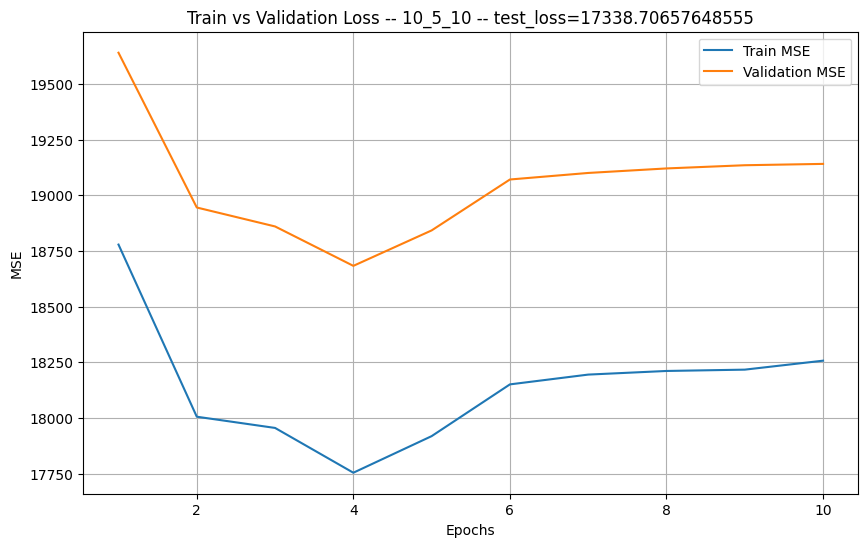

Training duration = 317.17924404144287


In [45]:
os.makedirs("models", exist_ok=True)
os.makedirs("images", exist_ok=True)

model_folder="models/random_forest"
image_folder="images/random_forest"
import time
start_time = time.time()
train_mse, val_mse, test_mse = train_rt(X_train, y_train, 
             X_val, 
             y_val,
             X_test,
             y_test,
             n_trees=10, 
             max_depth=5,  
             num_epochs=10,
             model_folder=model_folder,
             image_folder=image_folder)
duration = time.time() - start_time
print(f"Training duration = {duration}")

In [57]:
def demo_rf_price(rf_model_fp, data_sample, categorical_features, numerical_features, encoder, scaler):
    """
    Predict the sale price using a trained Random Forest model.

    Parameters:
        rf_model (RandomForest): Trained Random Forest model.
        data_sample (dict): New sample data as a dictionary.
        categorical_features (list): List of categorical feature names.
        numerical_features (list): List of numerical feature names.
        encoder (CustomOneHotEncoder): Fitted one-hot encoder for categorical features.
        scaler (CustomStandardScaler): Fitted standard scaler for numerical features.
    """
    # Convert the sample data to a DataFrame
    data_sample_df = pd.DataFrame(data_sample)

    # Apply one-hot encoding to categorical columns
    new_data_cat = encoder.transform(data_sample_df[categorical_features])
    
    # Scale numerical columns
    new_data_num = scaler.transform(data_sample_df[numerical_features])
    
    # Combine processed numerical and categorical features
    new_data_processed = np.hstack([new_data_num, new_data_cat])

    rf_model = torch.load(rf_model_fp, weights_only=False)
    # Predict sale price using the Random Forest model
    predicted_price = rf_model.predict(new_data_processed)

    # Print the predicted sale price
    print(f"Predicted Sale Price: {predicted_price[0]:.2f}")


In [58]:
best_model_fp = "models/random_forest/10_5_10.pth"
# best_model_fp = "training_mae_2000.pt"
categorical_features = ['Order Date', 'Brand', 'Sneaker Name', 'Release Date', 'Buyer Region']
numerical_features = ['Retail Price', 'Shoe Size']

new_data = {
    'Order Date': ['2022-01-01'],
    'Brand': ['Yeezy'],
    'Sneaker Name': ['Adidas-Yeezy-Boost-350-V2-Core-Black-Red'],
    'Retail Price': [220],
    'Release Date': ['2018-02-11'],
    'Shoe Size': [11.0],
    'Buyer Region': ['California']
}
from utils import CustomOneHotEncoder, StandardScaler

encoder_scaler_fp = os.path.join(data_folder_fp, "encoder_scaler.pt")
encoder, scaler = torch.load(encoder_scaler_fp, weights_only=False)
demo_rf_price(best_model_fp, new_data, categorical_features, numerical_features, encoder, scaler)

Predicted Sale Price: 584.09
